In [1]:
import sys
#print(sys.path)
# sys.path.insert(0, '/eos/user/c/czeh/.local/lib/python3.9/site-packages')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

The scikit-learn version is 1.5.1.
Python version
3.11.9 (main, Jun 24 2024, 14:32:54) [GCC 11.3.0]
Version info.
sys.version_info(major=3, minor=11, micro=9, releaselevel='final', serial=0)


In [34]:
#from code import utils
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as pyg

import awkward as ak
import numpy as np
import uproot as uproot


%matplotlib inline

In [4]:
# use this to load the tree if some of file.keys() are duplicates ending with different numbers
def load_branch_with_highest_cycle(file, branch_name):

    # Get all keys in the file
    all_keys = file.keys()

    # Filter keys that match the specified branch name
    matching_keys = [key for key in all_keys if key.startswith(branch_name)]

    if not matching_keys:
        raise ValueError(f"No branch with name '{branch_name}' found in the file.")

    # Find the key with the highest cycle
    highest_cycle_key = max(matching_keys, key=lambda key: int(key.split(";")[1]))

    # Load the branch with the highest cycle
    branch = file[highest_cycle_key]

    return branch

In [15]:
input_folder = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv5Performance/CloseByPionPU/histo/"
files = glob.glob(f"{input_folder}/*.root")
file = uproot.open(files[0])
print(file.keys())

alltracksters = load_branch_with_highest_cycle(file,'ticlDumper/trackstersCLUE3DHigh')
allsimtrackstersCP = load_branch_with_highest_cycle(file, 'ticlDumper/simtrackstersCP')
allassociations = load_branch_with_highest_cycle(file, 'ticlDumper/associations')
print(alltracksters.show())
print(allsimtrackstersCP.show())
print(allassociations.show())

['ticlDumper;1', 'ticlDumper/trackstersCLUE3DHigh;2', 'ticlDumper/trackstersCLUE3DHigh;1', 'ticlDumper/trackstersTiclCandidate;2', 'ticlDumper/trackstersTiclCandidate;1', 'ticlDumper/simtrackstersSC;1', 'ticlDumper/simtrackstersCP;1', 'ticlDumper/simtracksters2HitsSC;1', 'ticlDumper/simtracksters2HitsCP;1', 'ticlDumper/trackstersSuperclusteringDNN;1', 'ticlDumper/candidates;1', 'ticlDumper/associations;1', 'ticlDumper/tracks;1', 'ticlDumper/simTICLCandidate;1']
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | edm::EventID             | AsGroup(<TBranchElement 'ev...
event/run_           | uint32_t                 | AsDtype('>u4')
event/luminosityB... | uint32_t                 | AsDtype('>u4')
event/event_         | uint64_t                 | AsDtype('>u8')
NTracksters          | uint32_t                 | AsDtype('>u4')
NClusters            | uint32_t

In [48]:
node_feature_names = ["time", "timeError", "regressed_energy", "raw_em_energy", "raw_pt", "raw_em_pt", "barycenter_x", "barycenter_y", "barycenter_z", "barycenter_eta", "barycenter_phi", "EV1", "EV2", "EV3", "eVector0_x", "eVector0_y", "eVector0_z", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3"]
data = alltracksters.arrays(node_feature_names)
data

<Array [{time: [...], ...}, {...}, ..., {...}] type='50 * {time: var * floa...'>

100%|██████████| 20/20 [00:24<00:00,  1.24s/it]
/tmp/ipykernel_490/3763898370.py:16: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


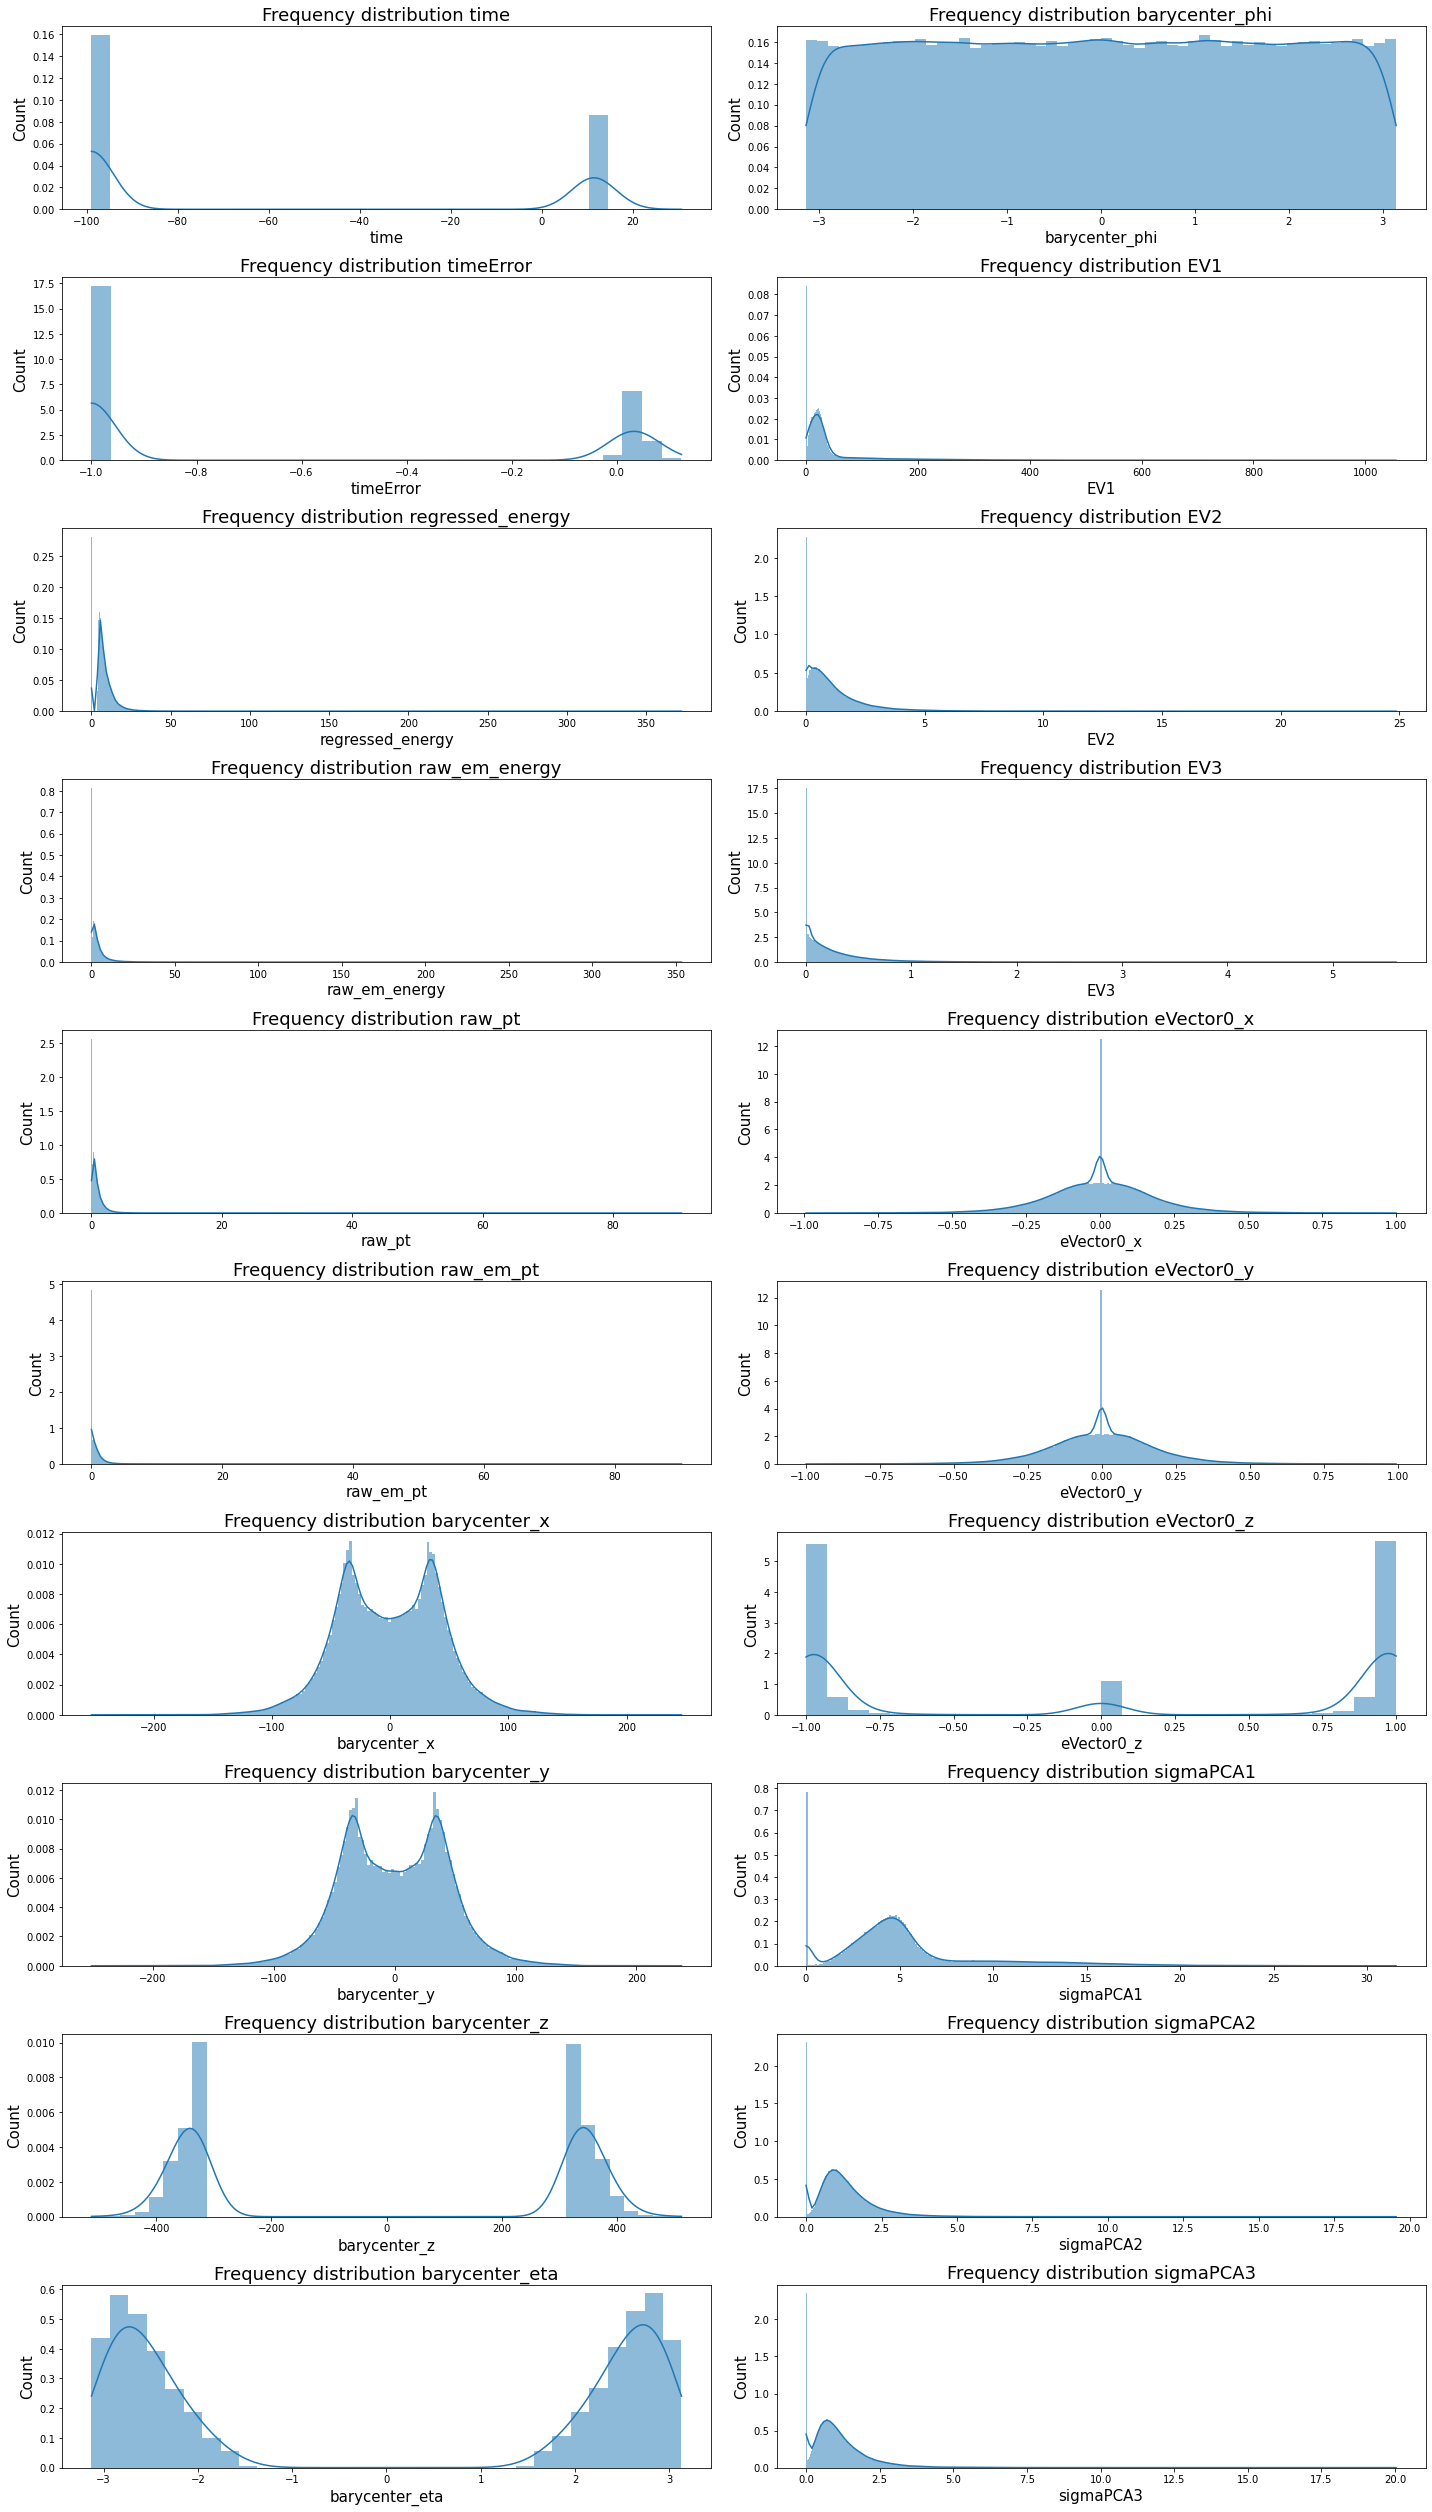

In [49]:
scols = int(np.ceil(len(node_feature_names)/2))
srows = 2
fig, axes = plt.subplots(scols, srows, figsize=(20, 35), constrained_layout=True)

for i in tqdm(range(len(node_feature_names))):
    feature = node_feature_names[i]
    ax_col = int(i%scols)
    ax_row = int(i/scols)
    
    values = ak.flatten(data[feature])
    sns.histplot(values, ax=axes[ax_col, ax_row], kde=True, stat="density", linewidth=0)
    axes[ax_col, ax_row].set_title('Frequency distribution '+ feature, fontsize=18)
    axes[ax_col, ax_row].set_xlabel(feature, fontsize=15)
    axes[ax_col, ax_row].set_ylabel('Count', fontsize=15)
    
fig.tight_layout()
plt.show()

In [56]:
track_vals = np.zeros((len(data), len(node_feature_names)))

for i in tqdm(range(len(data))):
    track = data[i]
    for j in range(len(node_feature_names)):
        track_vals[i, j] = ak.mean(track[node_feature_names[j]])

print(track_vals)

[[-6.11215571e+01 -6.45380427e-01  8.38276045e+00  3.95919662e+00
   8.45068213e-01  7.66175324e-01  8.61446438e-01  7.55276608e-01
   7.16495402e+00  5.22710898e-02  4.39234639e-02  4.51551444e+01
   1.12816036e+00  2.49392192e-01  1.64378441e-03  6.05595864e-03
   2.10256634e-02  5.25221963e+00  1.21703414e+00  1.08428836e+00]
 [-6.13569554e+01 -6.47312363e-01  8.36266195e+00  3.83145915e+00
   8.54635311e-01  7.57033970e-01 -2.11991955e+00 -9.31191350e-01
   1.69414879e+01  1.25482543e-01 -3.94009751e-02  4.41467956e+01
   1.19272257e+00  2.56130145e-01 -5.46051136e-03 -5.35456405e-03
   4.62389535e-02  5.24716713e+00  1.26589685e+00  1.12400153e+00]
 [-6.18046934e+01 -6.51299889e-01  8.34911634e+00  3.93622023e+00
   8.38011049e-01  7.50719758e-01  4.45453635e-01 -1.92833055e+00
  -4.31882864e+00 -2.89303640e-02 -2.53025526e-02  4.51179015e+01
   1.14894462e+00  2.56256652e-01 -4.73396001e-03 -6.63384516e-04
  -1.39347734e-02  5.28092997e+00  1.24544701e+00  1.12020881e+00]
 [-5.93

100%|██████████| 20/20 [00:02<00:00,  6.92it/s]
/tmp/ipykernel_490/3953163200.py:15: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


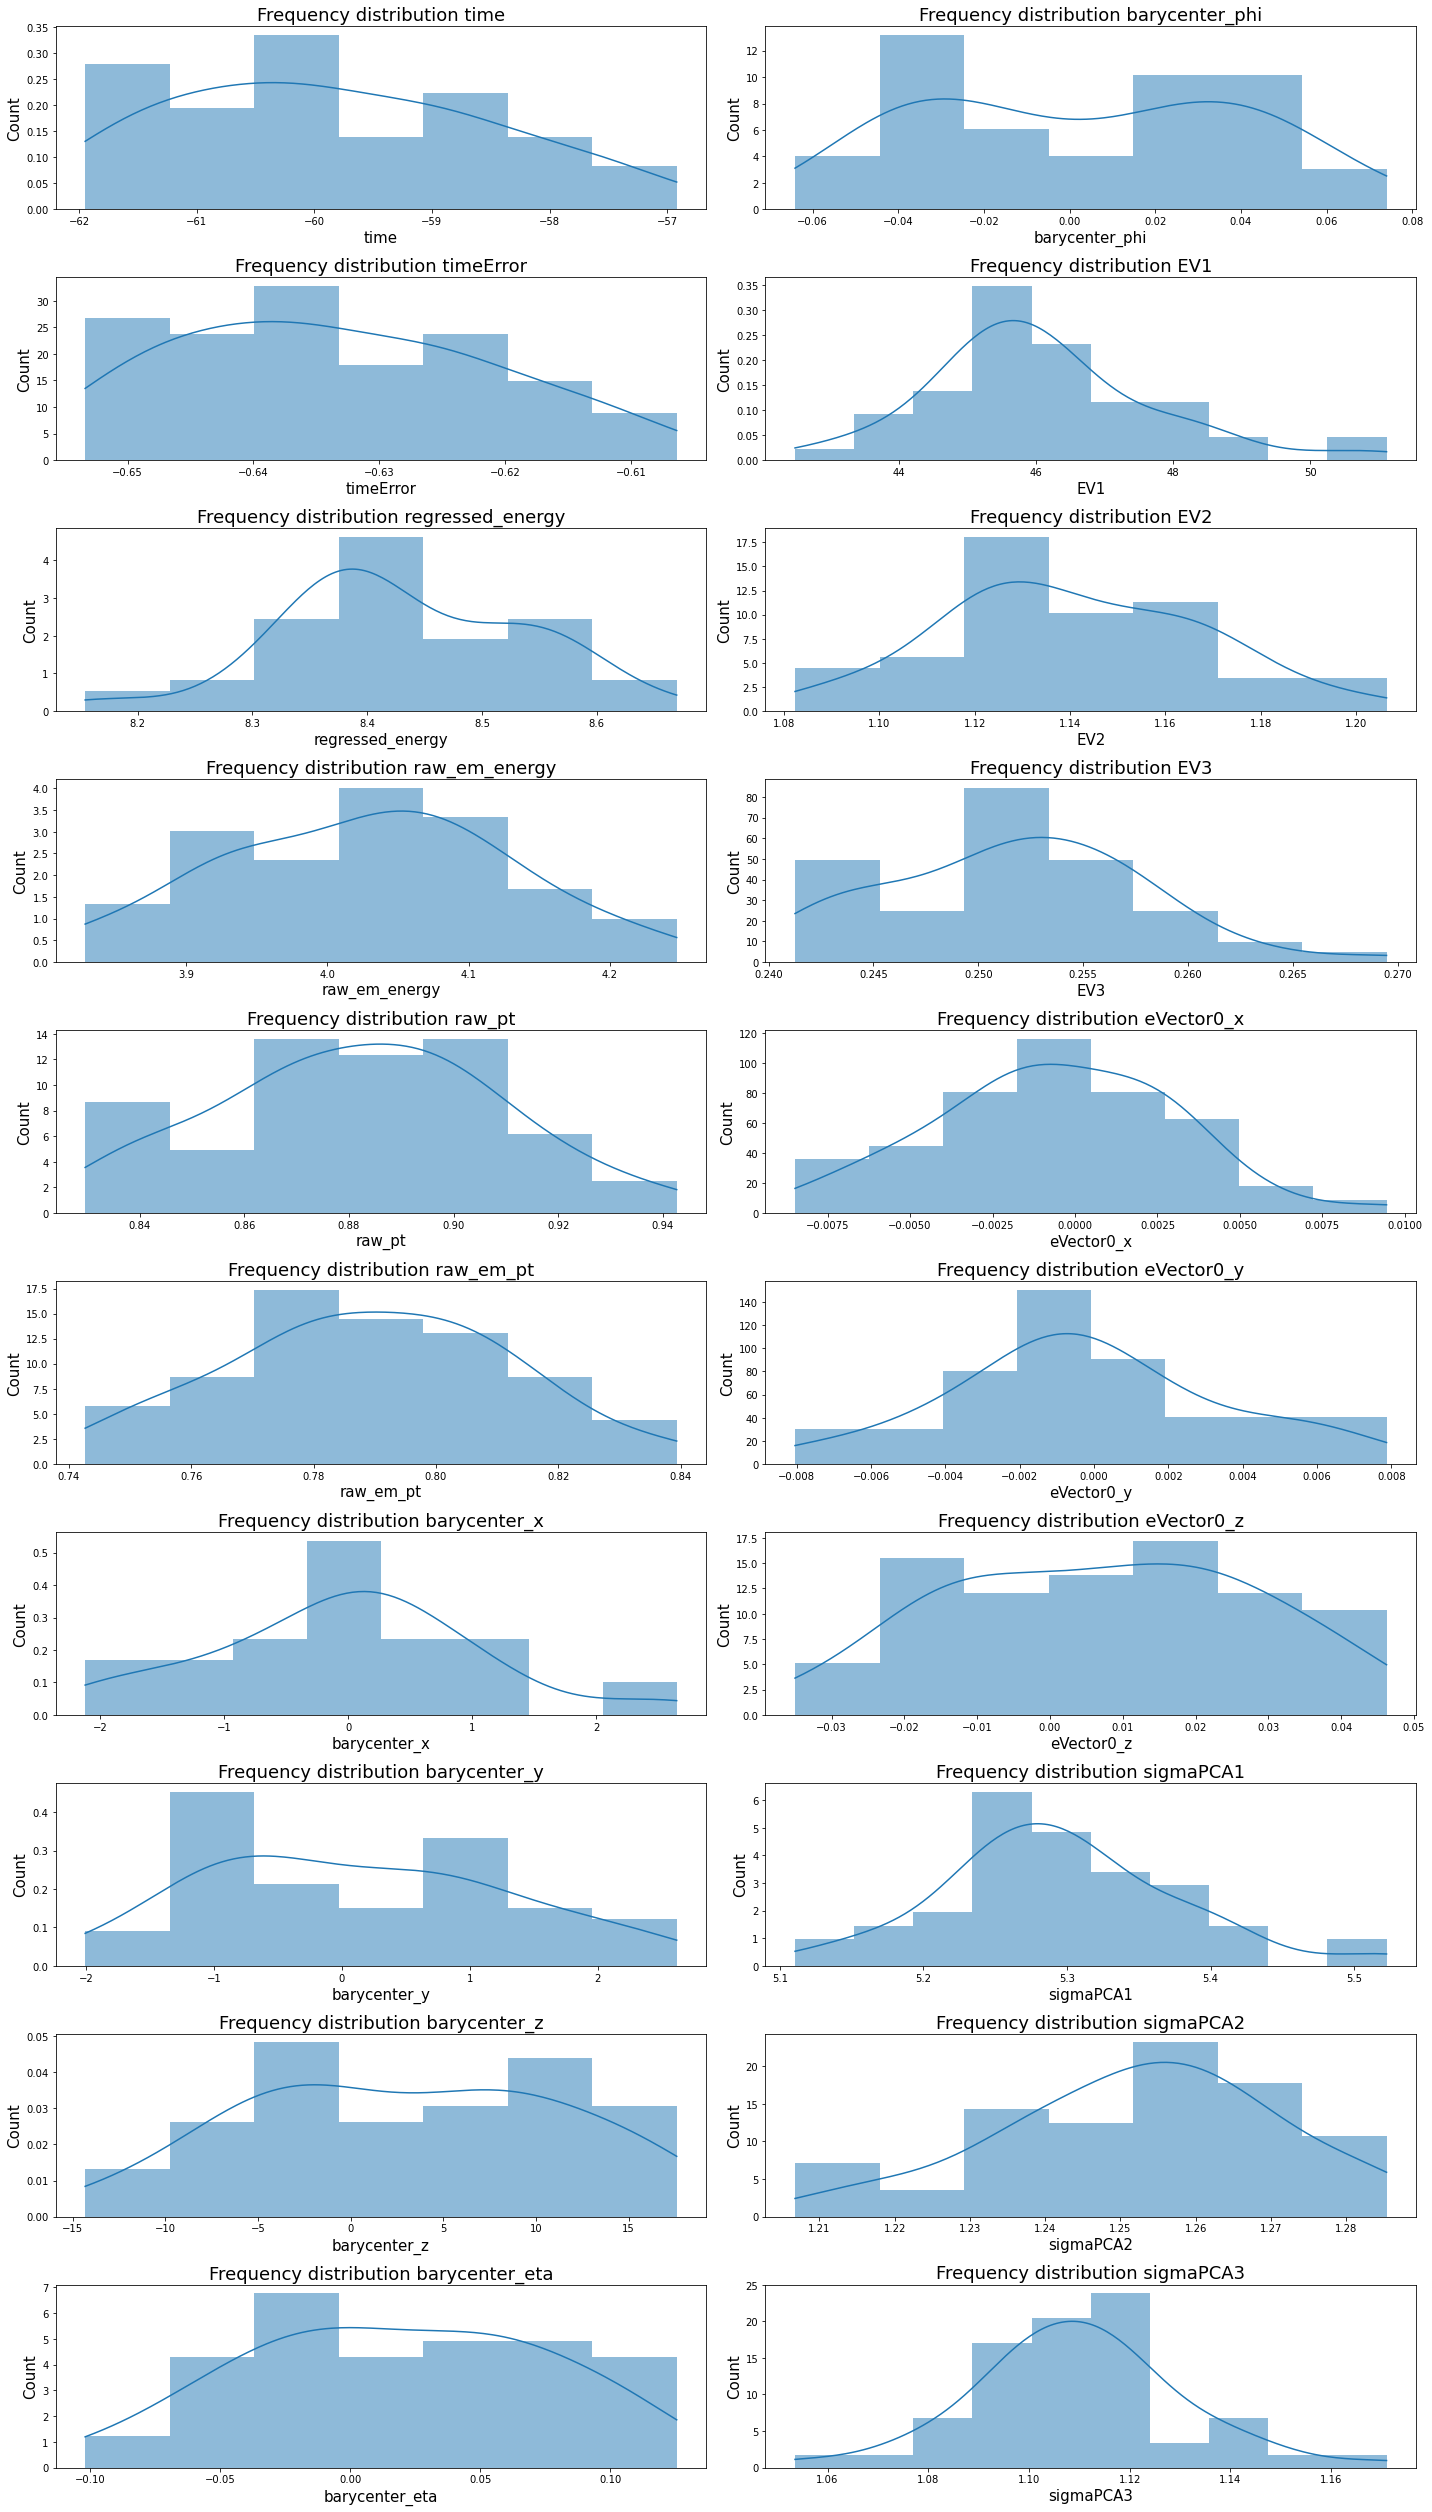

In [58]:
scols = int(np.ceil(len(node_feature_names)/2))
srows = 2
fig, axes = plt.subplots(scols, srows, figsize=(20, 35), constrained_layout=True)

for i in tqdm(range(len(node_feature_names))):
    feature = node_feature_names[i]
    ax_col = int(i%scols)
    ax_row = int(i/scols)
    
    sns.histplot(track_vals[:, i], ax=axes[ax_col, ax_row], kde=True, stat="density", linewidth=0)
    axes[ax_col, ax_row].set_title('Frequency distribution '+ feature, fontsize=18)
    axes[ax_col, ax_row].set_xlabel(feature, fontsize=15)
    axes[ax_col, ax_row].set_ylabel('Count', fontsize=15)
    
fig.tight_layout()
plt.show()

In [64]:
corr_matrix = np.corrcoef(track_vals.T)
print(corr_matrix.shape)

(20, 20)


Text(0.5, 1.0, 'Correlation Matrix of the Trackster Features')

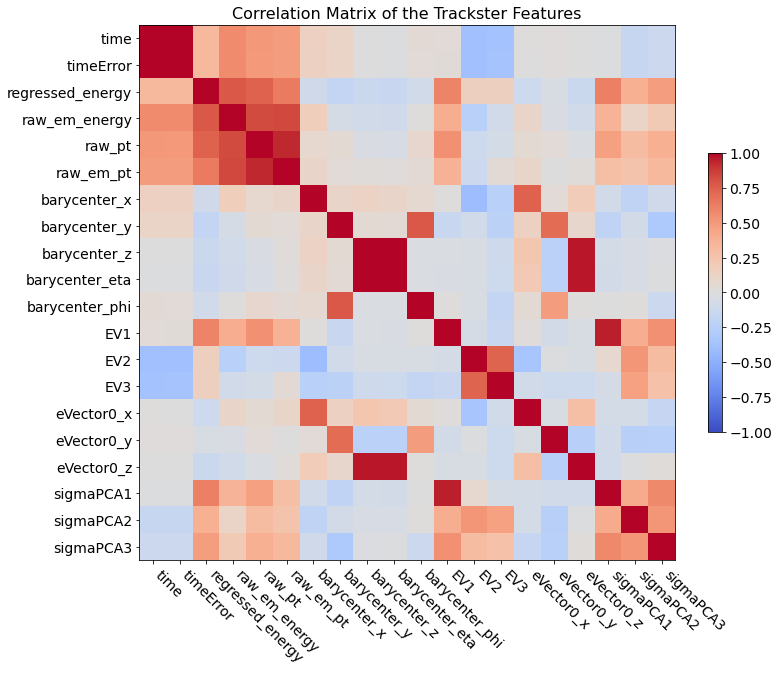

In [65]:
f = plt.figure(figsize=(12, 10))
plt.matshow(corr_matrix, fignum=f.number, cmap='coolwarm', vmin=-1, vmax=1)

plt.xticks(range(len(node_feature_names)), node_feature_names, fontsize=14, rotation=-45, ha="left")
plt.yticks(range(len(node_feature_names)), node_feature_names, fontsize=14)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix of the Trackster Features', fontsize=16)